#### Electoral parties

In [12]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

In [13]:
# read data
data = pd.read_stata("./data/rep_clark_2006a.dta")
data = data[["enep1", "eneg", "logmag", "uppertier", "enpres", "proximity1"]]

# train_x: eneg, logmag, uppertier, enpres, proximity1
train_x = torch.tensor((data.eneg.values, data.logmag.values, data.uppertier.values,\
    data.enpres.values, data.proximity1.values)).t().double()
train_y = torch.tensor(data.enep1.values).double()

In [14]:
from gpytorch.models import ExactGP

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = LinearMean(input_size=train_x.size(1), bias=True)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
likelihood = GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood).double()

# train model
model.train()
likelihood.train()

all_params = set(model.parameters())
optimizer = torch.optim.Adam(all_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f '  % (
            i , training_iter, loss.item()
        ))
    optimizer.step()

Iter 0/500 - Loss: 66.876 
Iter 50/500 - Loss: 1.956 
Iter 100/500 - Loss: 1.725 
Iter 150/500 - Loss: 1.650 
Iter 200/500 - Loss: 1.602 
Iter 250/500 - Loss: 1.563 
Iter 300/500 - Loss: 1.533 
Iter 350/500 - Loss: 1.514 
Iter 400/500 - Loss: 1.501 
Iter 450/500 - Loss: 1.488 


In [16]:
x_idx=0
moderator_idx=3
moderator_range=torch.linspace(0,7,101)

model.eval()
likelihood.eval()

N = moderator_range.shape[0]
mu_g = np.zeros((N,))
lower_g = np.zeros((N,))
upper_g = np.zeros((N,))

for j in range(N):
    test_x = train_x.clone()
    test_x[:,moderator_idx] = moderator_range[j]
    test_x = torch.autograd.Variable(torch.Tensor(test_x), requires_grad=True)

    # number of empirically sample 
    n_samples = 100

    with gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
        x_grad = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x = torch.stack([torch.autograd.grad(pred.sum(),\
                                        test_x, retain_graph=True)[0] for pred in sampled_pred])
    
    est_mean = x_grad.mean(axis=0)
    est_std = np.sqrt(sampled_dydtest_x.var((0,1))/train_x.size(0)/n_samples).round(decimals=5)

    mu_g[j] = est_mean[x_idx]
    lower_g[j] = est_mean[x_idx] - 2 * est_std[x_idx]
    upper_g[j] = est_mean[x_idx] + 2 * est_std[x_idx]


Text(0, 0.5, 'Marginal Effect of presidential elections on effective no. of parties')

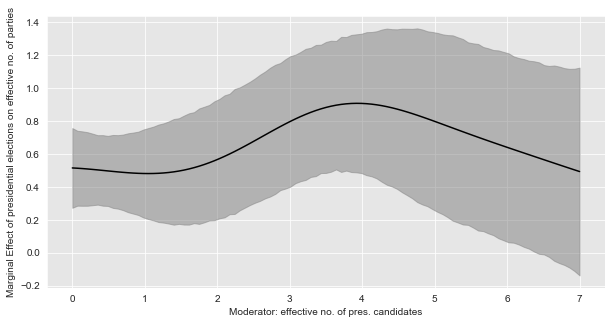

In [17]:
import seaborn as sns  
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(moderator_range, mu_g, color="black")
ax.fill_between(moderator_range,lower_g,upper_g,alpha=0.5,color="gray")
# ax.hist(data.enpres, color=None, edgecolor="gray", rwidth=0.1, fc=(1, 1, 1, 0.0))
plt.xlabel("Moderator: effective no. of pres. candidates")
plt.ylabel("Marginal Effect of presidential elections on effective no. of parties")

In [18]:
model.eval()
likelihood.eval()

BIC = (5+5+1+1)*torch.log(torch.tensor(train_x.size()[0])) + 2*loss*train_x.size()[0]
print("model evidence: {:0.3f} \n".format(-loss*train_x.size()[0]))
print("BIC: {:0.3f} \n".format(BIC))

model evidence: -716.946 

BIC: 1508.151 



In [19]:
import statsmodels.formula.api as sm
lm = sm.ols('enep1 ~ eneg+logmag+uppertier+enpres+proximity1+\
        logmag:eneg+uppertier:eneg+proximity1:enpres', data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  enep1   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     39.28
Date:                Tue, 31 Oct 2023   Prob (F-statistic):           5.38e-48
Time:                        17:51:11   Log-Likelihood:                -826.23
No. Observations:                 487   AIC:                             1670.
Df Residuals:                     478   BIC:                             1708.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9157      0.17